In [20]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft
from io import BytesIO

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

[[0.  0.  0. ]
 [0.5 0.5 0. ]
 [0.5 0.5 0. ]]
[[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.00000000e+00]]
[[ 0.         0.         0.       ]
 [ 0.6830127 -0.1830127  0.       ]
 [ 0.6830127 -0.1830127  0.       ]]
[[ 0.   0.   0. ]
 [ 0.5 -0.5  0. ]
 [ 0.5 -0.5  0. ]]


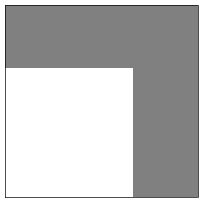

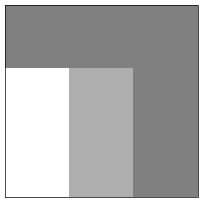

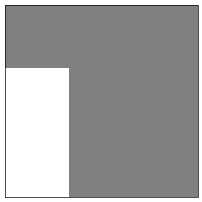

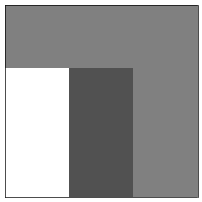

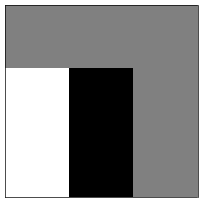

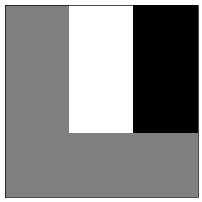

In [21]:

for beta2 in [0, 0.25, 0.5, 0.75, 1]:

    filters = np.zeros((3,3))



    t = np.zeros((2,2))
    t[0,1] = np.sqrt(beta2)
    t[0, 0] = np.sqrt(1-beta2)

    filters[1:,0:2] = fft.idctn(t, norm="ortho")
    print(filters)

    plt.imshow(filters, cmap='gray', vmin=-0.5, vmax=0.5)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks\

    plt.grid(True)
    plt.savefig(f"kernels/k2_beta2_{beta2}_1.pdf")


    filters = np.zeros((3,3))

    filters[0:2,1:] = fft.idctn(t, norm="ortho")
    plt.figure()

    plt.imshow(filters, cmap='gray', vmin=-0.5, vmax=0.5)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.grid(True)
    plt.savefig(f"kernels/k2_beta2_{beta2}_2.pdf")


[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]
[[0.49279928 0.28867513 0.08455099]
 [0.49279928 0.28867513 0.08455099]
 [0.49279928 0.28867513 0.08455099]]
[[ 0.52437739  0.23570226 -0.05297287]
 [ 0.52437739  0.23570226 -0.05297287]
 [ 0.52437739  0.23570226 -0.05297287]]
[[ 0.52022006  0.16666667 -0.18688672]
 [ 0.52022006  0.16666667 -0.18688672]
 [ 0.52022006  0.16666667 -0.18688672]]
[[ 0.40824829  0.         -0.40824829]
 [ 0.40824829  0.         -0.40824829]
 [ 0.40824829  0.         -0.40824829]]


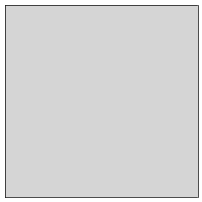

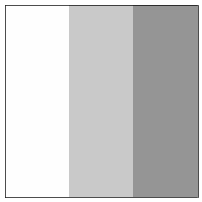

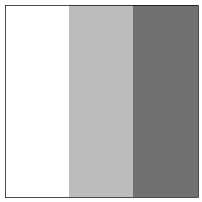

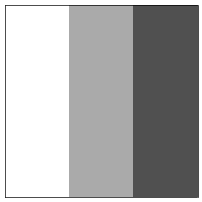

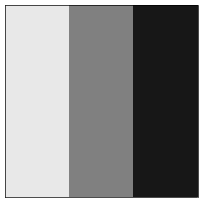

In [22]:

for beta2 in [0, 0.25, 0.5, 0.75, 1]:

    filters = np.zeros((3,3))



    t = np.zeros((3,3))
    t[0,1] = np.sqrt(beta2)
    t[0, 0] = np.sqrt(1-beta2)

    filters = fft.idctn(t, norm="ortho")
    print(filters)
    plt.figure()

    plt.imshow(filters, cmap='gray', vmin=-0.5, vmax=0.5)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks\

    plt.grid(True)
    plt.savefig(f"kernels/k3_beta2_{beta2}.pdf")


BETA2 tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(
[[0.  0.5 0. ]
 [0.5 0.  0.5]
 [0.  0.5 0. ]], shape=(3, 3), dtype=float32)
BETA2 tf.Tensor(0.25, shape=(), dtype=float32)
tf.Tensor(
[[0.         0.28867513 0.        ]
 [0.28867513 0.         0.86602545]
 [0.         0.28867513 0.        ]], shape=(3, 3), dtype=float32)
BETA2 tf.Tensor(0.50000006, shape=(), dtype=float32)
tf.Tensor(
[[0.         0.14942925 0.        ]
 [0.14942925 0.         0.9659258 ]
 [0.         0.14942925 0.        ]], shape=(3, 3), dtype=float32)
BETA2 tf.Tensor(0.75, shape=(), dtype=float32)
tf.Tensor(
[[0.0000000e+00 1.4901161e-08 0.0000000e+00]
 [1.4901161e-08 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.4901161e-08 0.0000000e+00]], shape=(3, 3), dtype=float32)
BETA2 tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(
[[ 0.         -0.28867513  0.        ]
 [-0.28867513  0.          0.86602545]
 [ 0.         -0.28867513  0.        ]], shape=(3, 3), dtype=float32)


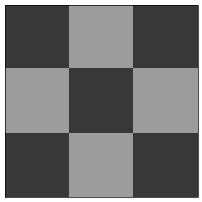

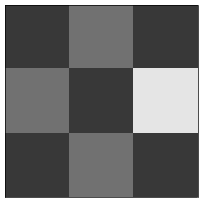

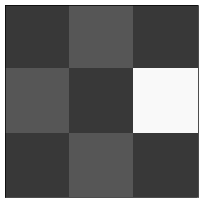

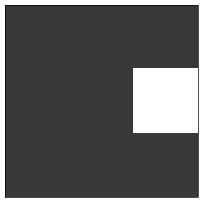

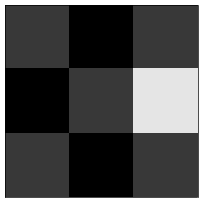

In [43]:
for beta2 in [0, 0.25, 0.5, 0.75, 1]:

    filters = np.array([[0,0,0],
                       [0,0,1],
                       [0,0,0]])
    filters = tf.cast(tf.reshape(filters, (3,3,1,1)), tf.float32)
    fs, fa = getSymAntiSymTF(tf.reshape(filters, (3,3,1,1)))
    fs = (fs)/(tf.math.reduce_euclidean_norm(fs))
    fa = (fa)/(tf.math.reduce_euclidean_norm(fa))


    s,a = getSymAntiSymTF(filters)

    filters = fa*( np.sqrt(beta2)) + fs*( np.sqrt(1-beta2))
		#filters /= np.sum(np.abs(filters))
    s,a = getSymAntiSymTF(filters)
    print("BETA2", tf.math.reduce_euclidean_norm(a)**2 / tf.math.reduce_euclidean_norm(filters)**2 )

    print(filters[:,:,0,0])

    plt.figure()
    plt.imshow(filters[:,:,0,0], cmap='gray', vmin=-0.288 ,vmax=1)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks\

    plt.grid(True)
    plt.savefig(f"kernels/k3_trans_beta2_{beta2}.pdf")

/tmp/ipykernel_12367/2133954249.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


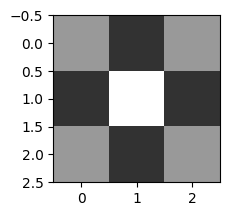

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from scipy.fft import idctn



N = 3
N_disp = 3
eps_const_raw = 1e-12   # constant-patch detection on *raw* IDCT
eps_zero_norm = 1e-6    # near-zero snap on *normalized* values

# 1) Build raw bases
bases_raw = np.zeros((N, N, N, N), dtype=float)  # [v,u,y,x]
is_const = np.zeros((N, N), dtype=bool)
for v in range(N):
    for u in range(N):
        T = np.zeros((N, N), dtype=float)
        T[v, u] = 1.0
        spatial = idctn(T, norm='ortho')
        bases_raw[v, u] = spatial
        # detect const on raw patch
        is_const[v, u] = np.ptp(spatial) < eps_const_raw

# 2) Global normalization to [0,1]
gmin = bases_raw.min()
gmax = bases_raw.max()
rng = gmax - gmin if gmax > gmin else 1.0
bases = (bases_raw - gmin) / rng


# constant -> white, near-zero -> 0
for v in range(N):
    for u in range(N):
        P = bases[v, u]
        if is_const[v, u]:
            P[:] = 1.0
        else:
            P[P < eps_zero_norm] = 0.0
        bases[v, u] = P

# --- figure with labeled headers and u/v wedge ---
fig = plt.figure(figsize=(9, 9))
gs  = fig.add_gridspec(N_disp+1, N_disp+1, wspace=0.05, hspace=0.05)

# corner wedge cell

for beta2 in [0, 0.25, 0.5, 0.75, 1]:



    filters = fa*( np.sqrt(beta2)) + fs*( np.sqrt(1-beta2))
		#filters /= np.sum(np.abs(filters))
    s,a = getSymAntiSymTF(filters)
    print("BETA2", tf.math.reduce_euclidean_norm(a)**2 / tf.math.reduce_euclidean_norm(filters)**2 )

    print(filters[:,:,0,0])

    plt.figure()
    plt.imshow(filters[:,:,0,0], cmap='gray', vmin=-0.288 ,vmax=1)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks\

    plt.grid(True)
    plt.savefig(f"kernels/k3_beta2_{beta2}.pdf")


ax = fig.add_subplot(gs[0, 0])
ax.imshow(bases[v, u], cmap="gray", vmin=0, vmax=1, interpolation="nearest")
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("dct_basis_8x8.pdf", dpi=300)

plt.show()
